# Config

In [1]:
import numpy as np
import matplotlib.pyplot as plt

M = 4
T=1
NL = 10000
SEED=42
errs = [0.00005, 0.0001, 0.0002, 0.0005, 0.001]
np.random.seed(SEED)

# Utility

In [42]:
def h(l, T=1):
    return M**(-l)*T
   
def optimal_N(V, err=1e-4):
    temp = 0
    for i in range(len(V)):
        temp += np.sqrt(V[i]*h(i))
        
    return [int(2*err**(-2)*np.sqrt(V[i]*h(i))*temp) for i in range(len(V))]

def optimal_N(V, err=1e-4):
    temp = 0
    for i in range(len(V)):
        temp += np.sqrt(V[i]*h(i))
    i = len(V)-1
    return int(2*err**(-2)*np.sqrt(V[i]*h(i))*temp)

def cal_cost(Nlist):
    costs = []
    for i in range(5):
        cost = Nlist[i][0]
        for j in range(1,len(Nlist[i])):
            cost += Nlist[i][j]*(M**j+M**(j-1))*0.5
        costs.append(cost*(errs[i]**2))
    return costs

def std_cost(V, Nlist):
    costs = []
    for j in range(5):
        cost = 0
        err = errs[j]
        l = len(Nlist[j])
        for i in range(l):
            cost += 2*V[i]*M**i
        costs.append(cost)
    return costs

# MLMC

In [44]:
def mlmc(sim_method, L=5, err=1e-4):
    V = []
    V2 = [0]
    N = []
    P = []
    Pa = []
    Y = [0]
    l = 0
    converge = False
    
    n_steps_fine = int(T / h(L-1))
    W = [np.sqrt(h(L-1)) * np.random.randn(NL) for _ in range(n_steps_fine)]

    W_l_dict = {L-1: W}

    for l in range(L-2, -1, -1):
        dt_l = h(l)
        n_steps_l = int(T / dt_l)
        W_l_dict[l] = [sum(W_l_dict[l+1][i*M : (i+1)*M]) for i in range(n_steps_l)]

    #while (l < 2 or not converge) and l<L:
    while l < L:
        pl, vl, parray = sim_method(W_l_dict[l], dt=h(l))
        #pl, vl, parray = sim_method(dt=h(l))
        P.append(pl)
        V.append(vl)
        Pa.append(parray)
        
        #N = optimal_N(V, err)
        #Nl = N[-1]
        Nl = optimal_N(V, err)
        N.append(Nl)
        
        if l >= 1:
            Yl = np.mean(Pa[l][:Nl]-Pa[l-1][:Nl])
            v2 = np.var(Pa[l][:Nl]-Pa[l-1][:Nl])
            Y.append(Yl)
            V2.append(v2)
            if l >= 2:
                converge = (max(abs(Y[l-1])/M, abs(Y[l])) < err*(M-1)/np.sqrt(2))
        
        l += 1
    
    return V, V2, P, Y, N

In [4]:
def mlmc_Richardson(sim_method, L=5, err=1e-4):
    V = []    
    V2 = [0]  
    N = []    
    P = []     
    Y = [0]   
    Pa = []   
    l = 0
    converge = False
    
    n_steps_fine = int(T / h(L-1))

    W = [np.sqrt(h(L-1)) * np.random.randn(NL) for _ in range(n_steps_fine)]
    W_l_dict = {L-1: W}

    for lvl in range(L-2, -1, -1):
        dt_l = h(lvl)
        n_steps_l = int(T/dt_l)

        W_coarse = [np.sum(W_l_dict[lvl+1][i*M:(i+1)*M], axis=0)
                    for i in range(n_steps_l)]
        W_l_dict[lvl] = W_coarse


    while l < L-1:
    #while (l < 2 or not converge) and l<L-1:
        dt_coarse = h(l)  
        dt_fine   = h(l+1)  
        
        pl, vl, parray = sim_method(W_l_dict[l], W_l_dict[l+1],
                                    n_paths=NL, dt_coarse=dt_coarse, dt_fine=dt_fine)
        P.append(pl)
        V.append(vl)
        Pa.append(parray)
        
        #N = optimal_N(V, err)
        #Nl = N[-1]
        Nl = optimal_N(V, err)
        N.append(Nl)
        
        if l >= 1:
            diff = Pa[l][:Nl] - Pa[l-1][:Nl]
            Yl = np.mean(diff)
            v2 = np.var(diff, ddof=1)
            Y.append(Yl)
            V2.append(v2)
            if l >= 2:
                converge = (abs(Y[l]-Y[l-1]/M) < err*(M**2-1)/np.sqrt(2))
        l += 1

    dt_last = h(L-1)
    pl, vl, parray = sim_euro(W_l_dict[L-1], n_paths=NL, dt=dt_last)
    P.append(pl)
    V.append(vl)
    Pa.append(parray)

    return V, V2, P, Y, N

# 1. GBM

$dS = rSdt + \sigma SdW, 0<t<1$

## 1.1 European Option

$P = exp(-r)max(0, S(1)-1)$

In [5]:
def sim_euro(dW, n_paths=NL, dt=h(0), S0=1, r=0.05, sigma=0.2, T=1, K=1):
    S = np.full((n_paths,), S0, dtype=np.float64)
    
    n_steps = int(T/dt)
    for i in range(n_steps):
        #dW = np.sqrt(dt) * np.random.randn(n_paths)
        S += r * S * dt + sigma * S * dW[i]
    
    payoffs = np.exp(-r * T) * np.maximum(0, S - K)
    
    price = np.mean(payoffs)
    variance = np.var(payoffs, ddof=1)

    return price, variance, payoffs

In [29]:
V, V2, P, Y, N = mlmc(sim_euro)

C:\Users\Nvve\AppData\Local\Temp\ipykernel_17724\2112493830.py:3: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(V2) / np.log(M), label=r'$P_l-P_{l-1}$', marker='s', linestyle='--')


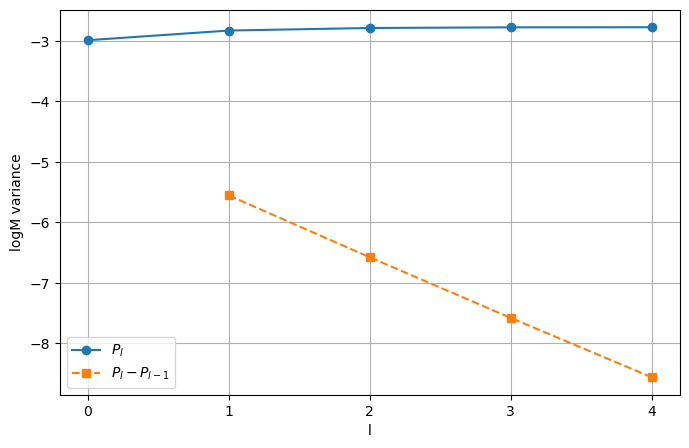

In [30]:
plt.figure(figsize=(8, 5))
plt.plot(np.log(V) / np.log(M), label=r'$P_l$', marker='o', linestyle='-')
plt.plot(np.log(V2) / np.log(M), label=r'$P_l-P_{l-1}$', marker='s', linestyle='--')


plt.xlabel("l")
plt.xticks([0, 1, 2, 3, 4]) 
plt.ylabel("logM variance")
#plt.title("LogM Value of V and V2")
plt.legend()
plt.grid(True)


plt.show()

C:\Users\Nvve\AppData\Local\Temp\ipykernel_17724\2661390140.py:6: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(Y) / np.log(M), label=r'$P_l-P_{l-1}$', marker='s', linestyle='--')
C:\Users\Nvve\AppData\Local\Temp\ipykernel_17724\2661390140.py:7: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(Y2) / np.log(M), label=r'$Y_l-Y_{l-1}/M$', marker='x', linestyle='-.')


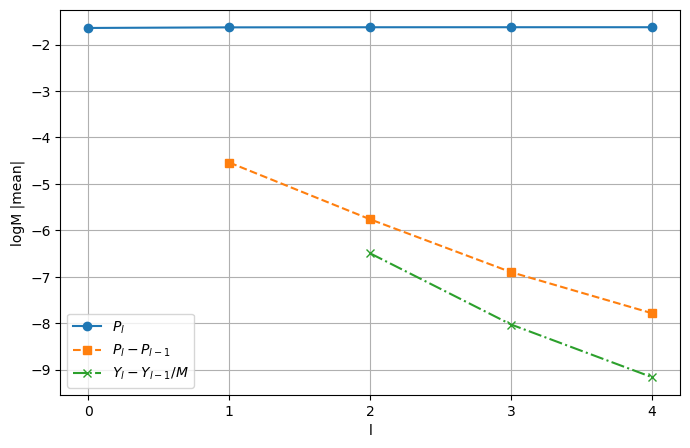

In [31]:
P2 = list(map(abs, Y))
Y2 = [0, 0] + [abs(Y[i]-Y[i-1]/4) for i in range(2, 5)]

plt.figure(figsize=(8, 5))
plt.plot(np.log(P) / np.log(M), label=r'$P_l$', marker='o', linestyle='-')
plt.plot(np.log(P2) / np.log(M), label=r'$P_l-P_{l-1}$', marker='s', linestyle='--')
plt.plot(np.log(Y2) / np.log(M), label=r'$Y_l-Y_{l-1}/M$', marker='x', linestyle='-.')

plt.xlabel("l")
plt.xticks([0, 1, 2, 3, 4]) 
plt.ylabel("logM |mean|")
#plt.title("Log4 Value of V and V2")
plt.legend()
plt.grid(True)


plt.show()

In [32]:
def sim_euro_ext(dW_coarse, dW_fine, n_paths=NL,
                         dt_coarse=None, dt_fine=None,
                         S0=1, r=0.05, sigma=0.2, T=1, K=1, p=1):
    S_coarse = np.full(n_paths, S0, dtype=np.float64)
    n_steps_coarse = int(T/dt_coarse)
    for i in range(n_steps_coarse):
        S_coarse += r * S_coarse * dt_coarse + sigma * S_coarse * dW_coarse[i]
    payoff_coarse = np.exp(-r*T) * np.maximum(0, S_coarse - K)
    price_coarse = np.mean(payoff_coarse)
    
    S_fine = np.full(n_paths, S0, dtype=np.float64)
    n_steps_fine = int(T/dt_fine)
    for i in range(n_steps_fine):
        S_fine += r * S_fine * dt_fine + sigma * S_fine * dW_fine[i]
    payoff_fine = np.exp(-r*T) * np.maximum(0, S_fine - K)
    price_fine = np.mean(payoff_fine)
    
    price_extr = (2**p * price_fine - price_coarse) / (2**p - 1)
    variance = np.var(payoff_fine, ddof=1)
    
    return price_extr, variance, payoff_fine

In [39]:
Nlist = []
for err in errs:
    _, _, _, _, Nx = mlmc(sim_euro, err=err)
    Nlist.append(Nx)
    
costs = cal_cost(Nlist)

Nlist_ext = []
for err in errs:
    _, _, _, _, Nx = mlmc_Richardson(sim_euro_ext, L=5, err=err)
    Nlist_ext.append(Nx)

costs_ext = cal_cost(Nlist_ext)

costs_std = std_cost(V, Nlist)
costs_std_ext = std_cost(V, Nlist_ext)

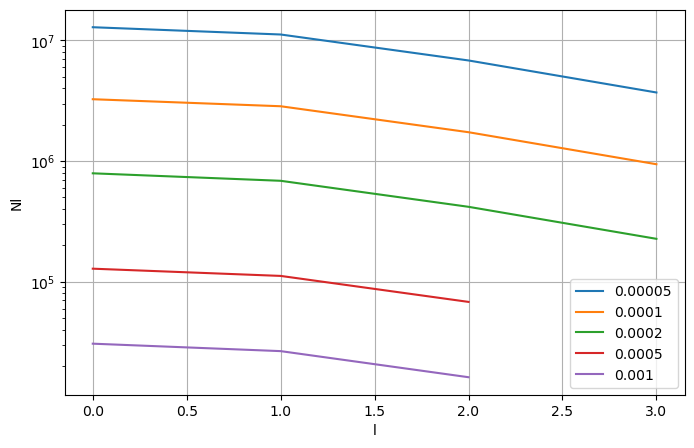

In [40]:
def pltNlist(Nlist):
    plt.figure(figsize=(8, 5))
    plt.plot(Nlist[0], label='0.00005')
    plt.plot(Nlist[1], label='0.0001')
    plt.plot(Nlist[2], label='0.0002')
    plt.plot(Nlist[3], label='0.0005')
    plt.plot(Nlist[4], label='0.001')

    plt.xlabel("l")
    plt.ylabel("Nl")
    plt.yscale('log')
    plt.legend()
    plt.grid(True)

    plt.show()

pltNlist(Nlist)

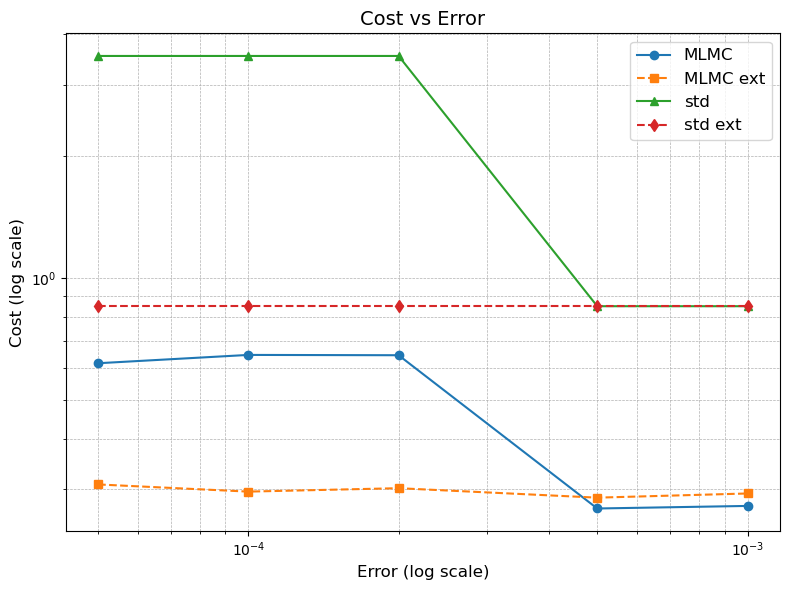

In [224]:
plt.figure(figsize=(8, 6))
plt.loglog(errs, costs, marker='o', linestyle='-', label='MLMC')
plt.loglog(errs, costs_ext, marker='s', linestyle='--', label='MLMC ext')
plt.loglog(errs, costs_std, marker='^', linestyle='-', label='std')
plt.loglog(errs, costs_std_ext, marker='d', linestyle='--', label='std ext')

plt.xlabel('Error (log scale)', fontsize=12)
plt.ylabel('Cost (log scale)', fontsize=12)
plt.title('Cost vs Error', fontsize=14)
plt.grid(True, which="both", ls="--", lw=0.5)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

## 1.2 Asian Option

$P = exp(-r)max(0, \bar S-1), where\, \bar S=\int ^1_0 S(t)dt$ approximated numerically by
$\bar S_l=\sum ^{N_l}_{n=1}\frac{1}{2}(\hat S_n + \hat S_{n-1})h_l$

In [43]:
def sim_asian(dW, n_paths=NL, dt=h(0), S0=1, r=0.05, sigma=0.2, T=1, K=1):
    n_steps = int(T / dt)
    S_path = np.full((n_steps + 1, n_paths), S0, dtype=np.float64)
    

    for i in range(1, n_steps + 1):
        S_path[i] = S_path[i-1] + r * S_path[i-1] * dt + sigma * S_path[i-1] * dW[i-1]

    avg_S = np.mean(S_path, axis=0)
    
    payoffs = np.exp(-r * T) * np.maximum(0, avg_S - K)
    price = np.mean(payoffs)
    variance = np.var(payoffs, ddof=1)
    return price, variance, payoffs

In [45]:
V, V2, P, Y, N = mlmc(sim_asian)

C:\Users\Nvve\AppData\Local\Temp\ipykernel_17724\2112493830.py:3: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(V2) / np.log(M), label=r'$P_l-P_{l-1}$', marker='s', linestyle='--')


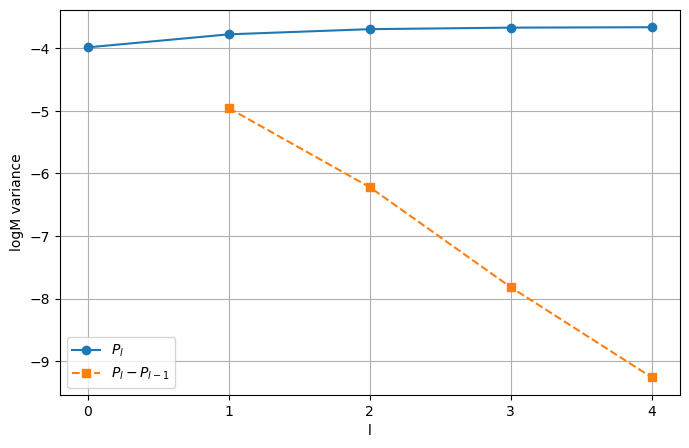

In [46]:
plt.figure(figsize=(8, 5))
plt.plot(np.log(V) / np.log(M), label=r'$P_l$', marker='o', linestyle='-')
plt.plot(np.log(V2) / np.log(M), label=r'$P_l-P_{l-1}$', marker='s', linestyle='--')


plt.xlabel("l")
plt.xticks([0, 1, 2, 3, 4]) 
plt.ylabel("logM variance")
#plt.title("LogM Value of V and V2")
plt.legend()
plt.grid(True)


plt.show()

C:\Users\Nvve\AppData\Local\Temp\ipykernel_17724\2661390140.py:6: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(Y) / np.log(M), label=r'$P_l-P_{l-1}$', marker='s', linestyle='--')
C:\Users\Nvve\AppData\Local\Temp\ipykernel_17724\2661390140.py:7: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(Y2) / np.log(M), label=r'$Y_l-Y_{l-1}/M$', marker='x', linestyle='-.')


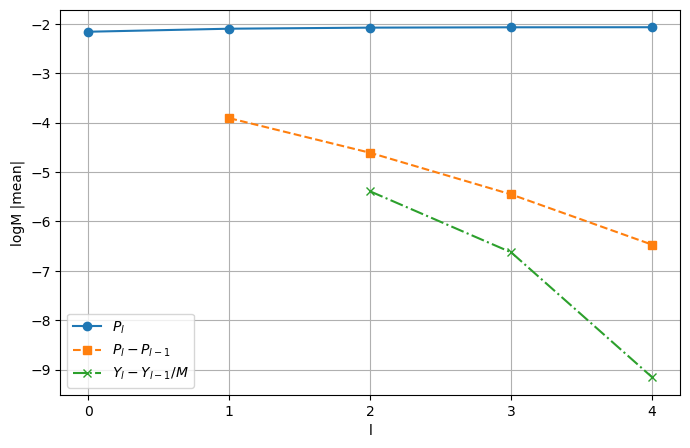

In [48]:
P2 = list(map(abs, Y))
Y2 = [0, 0] + [abs(Y[i]-Y[i-1]/4) for i in range(2, 5)]

plt.figure(figsize=(8, 5))
plt.plot(np.log(P) / np.log(M), label=r'$P_l$', marker='o', linestyle='-')
plt.plot(np.log(P2) / np.log(M), label=r'$P_l-P_{l-1}$', marker='s', linestyle='--')
plt.plot(np.log(Y2) / np.log(M), label=r'$Y_l-Y_{l-1}/M$', marker='x', linestyle='-.')

plt.xlabel("l")
plt.xticks([0, 1, 2, 3, 4]) 
plt.ylabel("logM |mean|")
#plt.title("Log4 Value of V and V2")
plt.legend()
plt.grid(True)


plt.show()

In [229]:
def sim_asian_ext(dW_coarse, dW_fine, n_paths=NL,
                  dt_coarse=None, dt_fine=None,
                  S0=1, r=0.05, sigma=0.2, T=1, K=1, p=1):
    n_steps_coarse = int(T / dt_coarse)
    S_path_coarse = np.full((n_steps_coarse + 1, n_paths), S0, dtype=np.float64)
    for i in range(1, n_steps_coarse + 1):
        S_path_coarse[i] = S_path_coarse[i-1] + r * S_path_coarse[i-1] * dt_coarse \
                           + sigma * S_path_coarse[i-1] * dW_coarse[i-1]
    avg_S_coarse = np.mean(S_path_coarse, axis=0)
    payoff_coarse = np.exp(-r * T) * np.maximum(0, avg_S_coarse - K)
    price_coarse = np.mean(payoff_coarse)
    
    n_steps_fine = int(T / dt_fine)
    S_path_fine = np.full((n_steps_fine + 1, n_paths), S0, dtype=np.float64)
    for i in range(1, n_steps_fine + 1):
        S_path_fine[i] = S_path_fine[i-1] + r * S_path_fine[i-1] * dt_fine \
                         + sigma * S_path_fine[i-1] * dW_fine[i-1]
    avg_S_fine = np.mean(S_path_fine, axis=0)
    payoff_fine = np.exp(-r * T) * np.maximum(0, avg_S_fine - K)
    price_fine = np.mean(payoff_fine)
    
    price_extr = (2**p * price_fine - price_coarse) / (2**p - 1)
    variance = np.var(payoff_fine, ddof=1)
    
    return price_extr, variance, payoff_fine

In [554]:
Nlist = []
for err in errs:
    _, _, _, _, Nx = mlmc(sim_asian, err=err)
    Nlist.append(Nx)
    
costs = cal_cost(Nlist)

Nlist_ext = []
for err in errs:
    _, _, _, _, Nx = mlmc_Richardson(sim_asian_ext, L=5, err=err)
    Nlist_ext.append(Nx)

costs_ext = cal_cost(Nlist_ext)

costs_std = std_cost(V, Nlist)
costs_std_ext = std_cost(V, Nlist_ext)

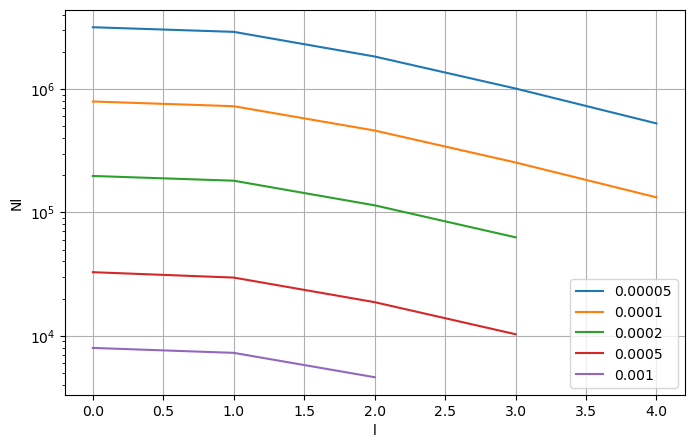

In [558]:
pltNlist(Nlist)

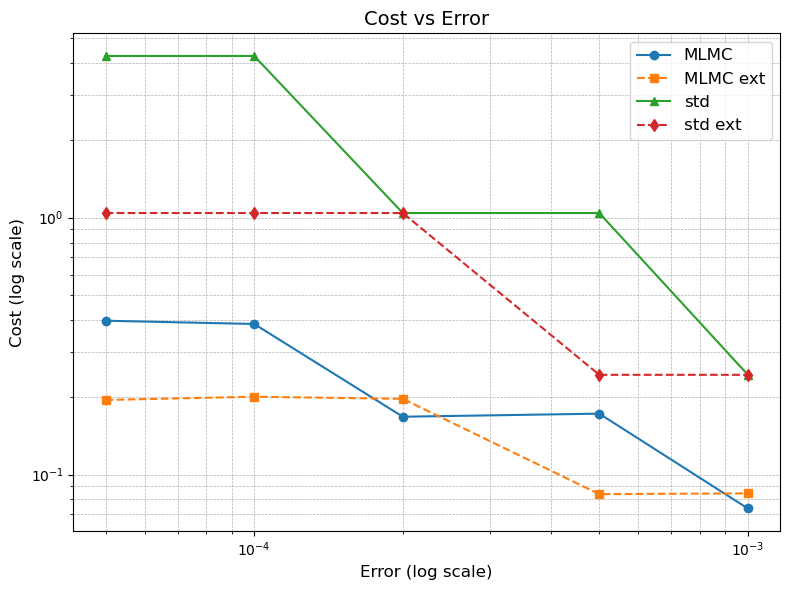

In [247]:
plt.figure(figsize=(8, 6))
plt.loglog(errs, costs, marker='o', linestyle='-', label='MLMC')
plt.loglog(errs, costs_ext, marker='s', linestyle='--', label='MLMC ext')
plt.loglog(errs, costs_std, marker='^', linestyle='-', label='std')
plt.loglog(errs, costs_std_ext, marker='d', linestyle='--', label='std ext')

plt.xlabel('Error (log scale)', fontsize=12)
plt.ylabel('Cost (log scale)', fontsize=12)
plt.title('Cost vs Error', fontsize=14)
plt.grid(True, which="both", ls="--", lw=0.5)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

## 1.3 Lookback Option

$P = exp(-r)(S(1)-min\, S(t))$, approximated numerically by $\hat{S}_{\min, l} = \left( \min_n \hat{S}_n \right) \left( 1 - \beta^* \sigma \sqrt{h_l} \right)$

In [49]:
def sim_lookback(dW, n_paths=NL, dt=h(0), S0=1, r=0.05, sigma=0.2, T=1):
    beta = 0.5826
    n_steps = int(T / dt)
    
    S = np.full(n_paths, S0, dtype=np.float64)
    min_S = np.full(n_paths, S0, dtype=np.float64)
    
    for i in range(n_steps):
        S += r * S * dt + sigma * S * dW[i]
        min_S = np.minimum(min_S, S)

    min_S_hat = min_S * (1 - beta * sigma * np.sqrt(dt))
    
    payoffs = np.exp(-r * T) * np.maximum(0, S - min_S_hat)
    
    price = np.mean(payoffs)
    variance = np.var(payoffs, ddof=1)
    
    return price, variance, payoffs

In [61]:
V, V2, P, Y, N = mlmc(sim_lookback, L=6)

C:\Users\Nvve\AppData\Local\Temp\ipykernel_17724\713608151.py:3: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(V2) / np.log(M), label=r'$P_l-P_{l-1}$', marker='s', linestyle='--')


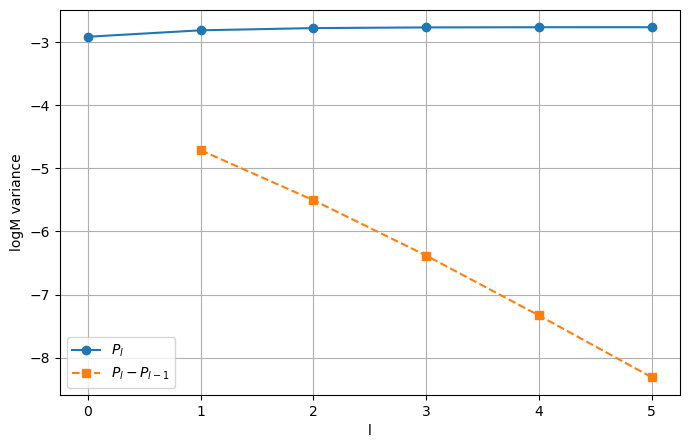

In [62]:
plt.figure(figsize=(8, 5))
plt.plot(np.log(V) / np.log(M), label=r'$P_l$', marker='o', linestyle='-')
plt.plot(np.log(V2) / np.log(M), label=r'$P_l-P_{l-1}$', marker='s', linestyle='--')


plt.xlabel("l")
plt.xticks([0, 1, 2, 3, 4, 5]) 
plt.ylabel("logM variance")
#plt.title("LogM Value of V and V2")
plt.legend()
plt.grid(True)


plt.show()

C:\Users\Nvve\AppData\Local\Temp\ipykernel_17724\1288784841.py:6: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(P2) / np.log(M), label=r'$P_l-P_{l-1}$', marker='s', linestyle='--')
C:\Users\Nvve\AppData\Local\Temp\ipykernel_17724\1288784841.py:7: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(Y2) / np.log(M), label=r'$Y_l-Y_{l-1}/M$', marker='x', linestyle='-.')


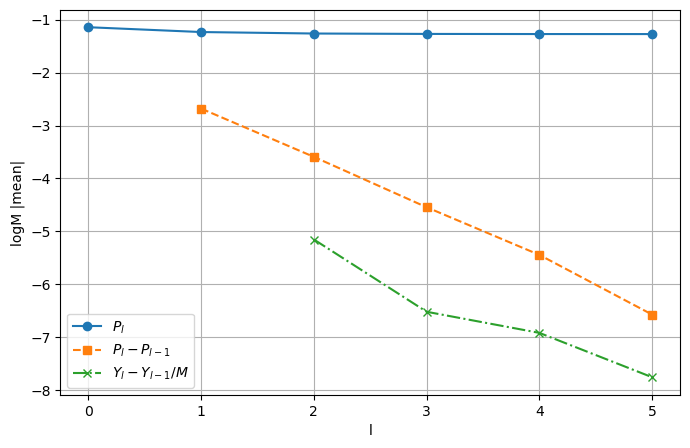

In [63]:
P2 = list(map(abs, Y))
Y2 = [0, 0] + [abs(Y[i]-Y[i-1]/4) for i in range(2, 6)]

plt.figure(figsize=(8, 5))
plt.plot(np.log(P) / np.log(M), label=r'$P_l$', marker='o', linestyle='-')
plt.plot(np.log(P2) / np.log(M), label=r'$P_l-P_{l-1}$', marker='s', linestyle='--')
plt.plot(np.log(Y2) / np.log(M), label=r'$Y_l-Y_{l-1}/M$', marker='x', linestyle='-.')

plt.xlabel("l")
plt.xticks([0, 1, 2, 3, 4, 5]) 
plt.ylabel("logM |mean|")
#plt.title("Log4 Value of V and V2")
plt.legend()
plt.grid(True)


plt.show()

In [352]:
def sim_lookback_ext(dW_coarse, dW_fine, n_paths=NL,
                     dt_coarse=None, dt_fine=None,
                     S0=1, r=0.05, sigma=0.2, T=1, p=1):

    beta = 0.5826
    
    n_steps_coarse = int(T / dt_coarse)
    S_coarse = np.full(n_paths, S0, dtype=np.float64)
    min_S_coarse = np.full(n_paths, S0, dtype=np.float64)
    for i in range(n_steps_coarse):
        S_coarse += r * S_coarse * dt_coarse + sigma * S_coarse * dW_coarse[i]
        min_S_coarse = np.minimum(min_S_coarse, S_coarse)
    min_S_hat_coarse = min_S_coarse * (1 - beta * sigma * np.sqrt(dt_coarse))
    payoff_coarse = np.exp(-r * T) * np.maximum(0, S_coarse - min_S_hat_coarse)
    price_coarse = np.mean(payoff_coarse)

    n_steps_fine = int(T / dt_fine)
    S_fine = np.full(n_paths, S0, dtype=np.float64)
    min_S_fine = np.full(n_paths, S0, dtype=np.float64)
    for i in range(n_steps_fine):
        S_fine += r * S_fine * dt_fine + sigma * S_fine * dW_fine[i]
        min_S_fine = np.minimum(min_S_fine, S_fine)
    min_S_hat_fine = min_S_fine * (1 - beta * sigma * np.sqrt(dt_fine))
    payoff_fine = np.exp(-r * T) * np.maximum(0, S_fine - min_S_hat_fine)
    price_fine = np.mean(payoff_fine)

    price_extr = (2**p * price_fine - price_coarse) / (2**p - 1)
    variance = np.var(payoff_fine, ddof=1)
    
    return price_extr, variance, payoff_fine

In [411]:
Nlist = []
for err in errs:
    _, _, _, _, Nx = mlmc(sim_lookback, L=6, err=err)
    Nlist.append(Nx)
    
costs = cal_cost(Nlist)

Nlist_ext = []
for err in errs:
    _, _, _, _, Nx = mlmc_Richardson(sim_lookback_ext, L=6, err=err)
    Nlist_ext.append(Nx)

costs_ext = cal_cost(Nlist_ext)

costs_std = std_cost(V, Nlist)
costs_std_ext = std_cost(V, Nlist_ext)

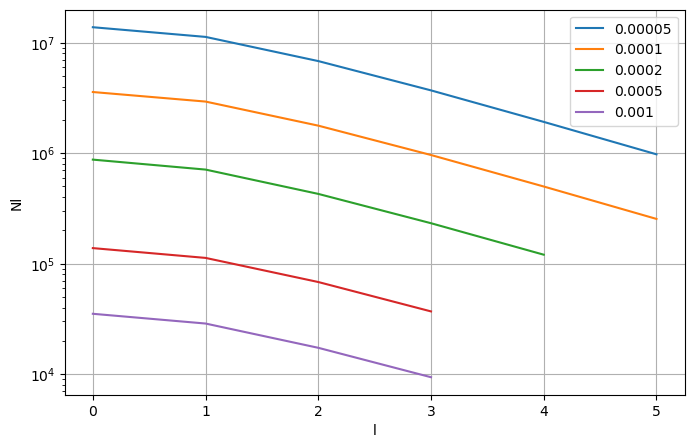

In [415]:
pltNlist(Nlist)

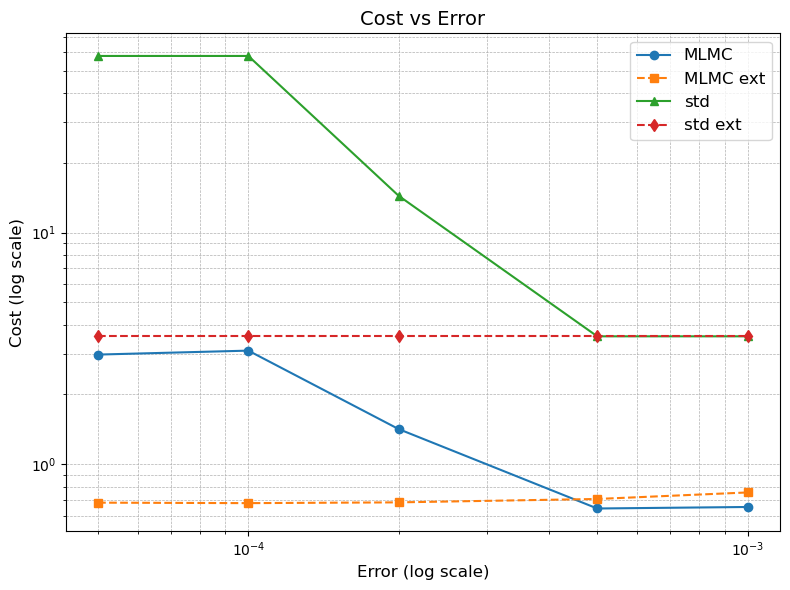

In [427]:
plt.figure(figsize=(8, 6))
plt.loglog(errs, costs, marker='o', linestyle='-', label='MLMC')
plt.loglog(errs, costs_ext, marker='s', linestyle='--', label='MLMC ext')
plt.loglog(errs, costs_std, marker='^', linestyle='-', label='std')
plt.loglog(errs, costs_std_ext, marker='d', linestyle='--', label='std ext')

plt.xlabel('Error (log scale)', fontsize=12)
plt.ylabel('Cost (log scale)', fontsize=12)
plt.title('Cost vs Error', fontsize=14)
plt.grid(True, which="both", ls="--", lw=0.5)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

## 1.4 Digital Option

$P = exp(-r)H(S(1)-1)$ ,where H(x) is the Heaviside function。

In [81]:
def sim_digital(dW, n_paths=NL, dt=h(0), S0=1, r=0.05, sigma=0.2, T=1, K=1):
    S = np.full(n_paths, S0, dtype=np.float64)
    n_steps = int(T / dt)

    for i in range(n_steps):
        S += r * S * dt + sigma * S * dW[i]
    
    payoffs = np.exp(-r * T) * (S > K).astype(np.float64)
    
    price = np.mean(payoffs)
    variance = np.var(payoffs, ddof=1)
    
    return price, variance, payoffs

In [82]:
V, V2, P, Y, N = mlmc(sim_digital)

C:\Users\Nvve\AppData\Local\Temp\ipykernel_17724\2112493830.py:3: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(V2) / np.log(M), label=r'$P_l-P_{l-1}$', marker='s', linestyle='--')


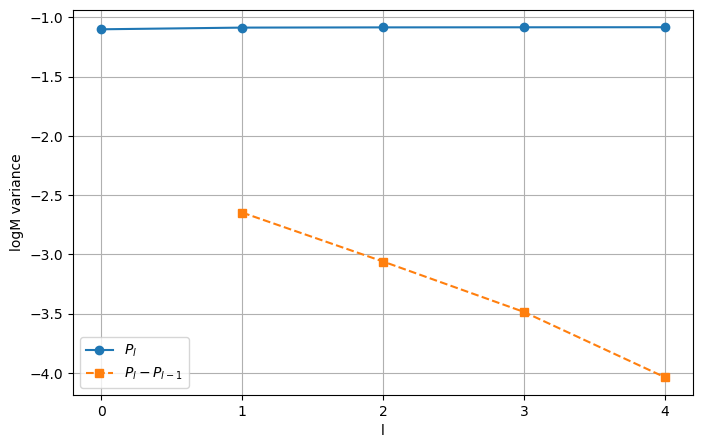

In [83]:
plt.figure(figsize=(8, 5))
plt.plot(np.log(V) / np.log(M), label=r'$P_l$', marker='o', linestyle='-')
plt.plot(np.log(V2) / np.log(M), label=r'$P_l-P_{l-1}$', marker='s', linestyle='--')


plt.xlabel("l")
plt.xticks([0, 1, 2, 3, 4]) 
plt.ylabel("logM variance")
#plt.title("LogM Value of V and V2")
plt.legend()
plt.grid(True)


plt.show()

C:\Users\Nvve\AppData\Local\Temp\ipykernel_17724\2738577475.py:6: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(P2) / np.log(M), label=r'$P_l-P_{l-1}$', marker='s', linestyle='--')
C:\Users\Nvve\AppData\Local\Temp\ipykernel_17724\2738577475.py:7: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(Y2) / np.log(M), label=r'$Y_l-Y_{l-1}/M$', marker='x', linestyle='-.')


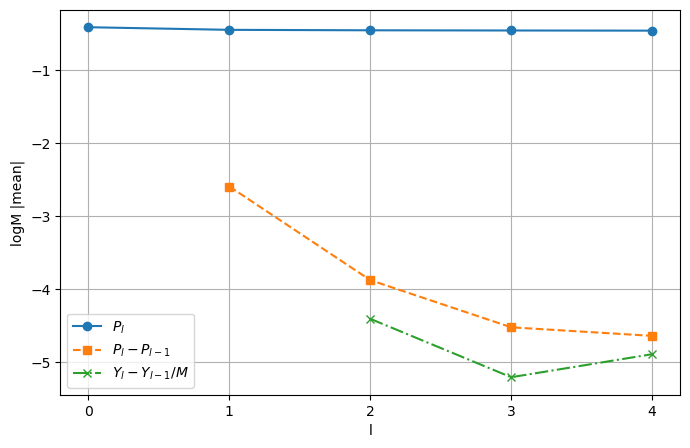

In [84]:
P2 = list(map(abs, Y))
Y2 = [0, 0] + [abs(Y[i]-Y[i-1]/4) for i in range(2, 5)]

plt.figure(figsize=(8, 5))
plt.plot(np.log(P) / np.log(M), label=r'$P_l$', marker='o', linestyle='-')
plt.plot(np.log(P2) / np.log(M), label=r'$P_l-P_{l-1}$', marker='s', linestyle='--')
plt.plot(np.log(Y2) / np.log(M), label=r'$Y_l-Y_{l-1}/M$', marker='x', linestyle='-.')

plt.xlabel("l")
plt.xticks([0, 1, 2, 3, 4]) 
plt.ylabel("logM |mean|")
#plt.title("Log4 Value of V and V2")
plt.legend()
plt.grid(True)


plt.show()

In [431]:
def sim_digital_ext(dW_coarse, dW_fine, n_paths=NL,
                    dt_coarse=None, dt_fine=None,
                    S0=1, r=0.05, sigma=0.2, T=1, K=1, p=1):

    n_steps_coarse = int(T / dt_coarse)
    S_coarse = np.full(n_paths, S0, dtype=np.float64)
    for i in range(n_steps_coarse):
        S_coarse += r * S_coarse * dt_coarse + sigma * S_coarse * dW_coarse[i]
    payoffs_coarse = np.exp(-r * T) * (S_coarse > K).astype(np.float64)
    price_coarse = np.mean(payoffs_coarse)

    n_steps_fine = int(T / dt_fine)
    S_fine = np.full(n_paths, S0, dtype=np.float64)
    for i in range(n_steps_fine):
        S_fine += r * S_fine * dt_fine + sigma * S_fine * dW_fine[i]
    payoffs_fine = np.exp(-r * T) * (S_fine > K).astype(np.float64)
    price_fine = np.mean(payoffs_fine)
    
    price_extr = (2**p * price_fine - price_coarse) / (2**p - 1)
    variance = np.var(payoffs_fine, ddof=1)
    
    return price_extr, variance, payoffs_fine

In [495]:
Nlist = []
for err in errs:
    _, _, _, _, Nx = mlmc(sim_digital, err=err)
    Nlist.append(Nx)
    
costs = cal_cost(Nlist)

Nlist_ext = []
for err in errs:
    _, _, _, _, Nx = mlmc_Richardson(sim_digital_ext, L=5, err=err)
    Nlist_ext.append(Nx)

costs_ext = cal_cost(Nlist_ext)

costs_std = std_cost(V, Nlist)
costs_std_ext = std_cost(V, Nlist_ext)

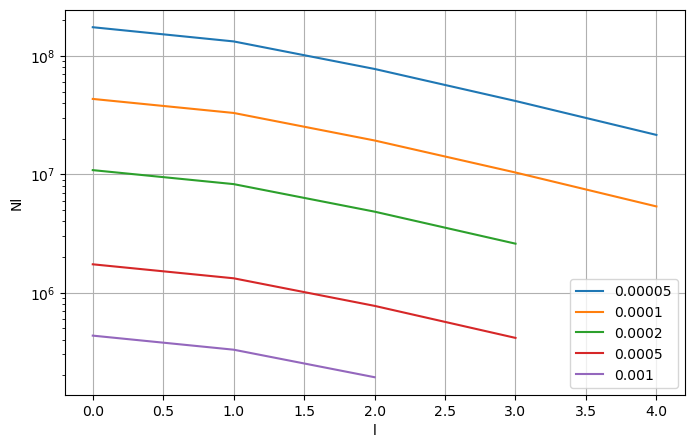

In [504]:
pltNlist(Nlist)

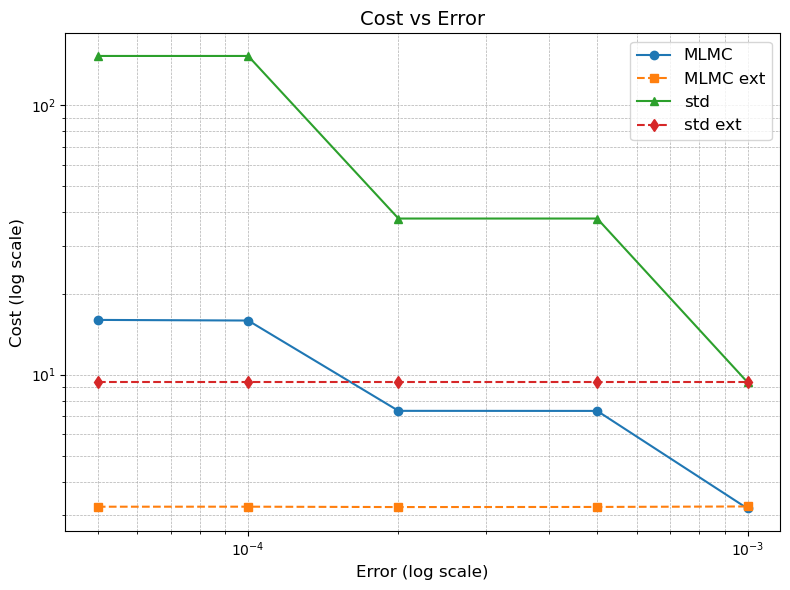

In [503]:
plt.figure(figsize=(8, 6))
plt.loglog(errs, costs, marker='o', linestyle='-', label='MLMC')
plt.loglog(errs, costs_ext, marker='s', linestyle='--', label='MLMC ext')
plt.loglog(errs, costs_std, marker='^', linestyle='-', label='std')
plt.loglog(errs, costs_std_ext, marker='d', linestyle='--', label='std ext')

plt.xlabel('Error (log scale)', fontsize=12)
plt.ylabel('Cost (log scale)', fontsize=12)
plt.title('Cost vs Error', fontsize=14)
plt.grid(True, which="both", ls="--", lw=0.5)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

# 2. Heston Stochastic Volatility Model

\begin{align*}
\mathrm{d}S &= rS\,\mathrm{d}t + \sqrt{V}S\,\mathrm{d}W_1, \quad 0 < t < 1, \\
\mathrm{d}V &= \lambda(\sigma^2 - V)\,\mathrm{d}t + \xi\sqrt{V}\,\mathrm{d}W_2,
\end{align*}

with $S(0) = 1$, $V(0) = 0.04$, $r = 0.05$, $\sigma = 0.2$, $\lambda = 5$, $\xi = 0.25$, and correlation $\rho = -0.5$ between $\mathrm{d}W_1$ and $\mathrm{d}W_2$.


The accuracy and variance are both improved by defining a new variable $W = e^{\lambda t}(V - \sigma^2)$,
and applying the Euler discretisation to the SDEs for $W$ and $S$, which results in the discrete equations
\begin{align*}
\hat{S}_{n+1} &= \hat{S}_n + r \hat{S}_n h + \sqrt{\hat{V}_n} \hat{S}_n \Delta W_{1,n}, \\
\hat{V}_{n+1} &= \sigma^2 + e^{-\lambda h} \left( \hat{V}_n - \sigma^2 \right) + \xi \sqrt{\hat{V}_n} \Delta W_{2,n}.
\end{align*}

In [85]:
def sim_euro_heston(
    dW1, dW2, n_paths=NL, dt=h(0), S0=1, V0=0.04,
    r=0.05, sigma=0.2, lambd=5.0, xi=0.25, T=1, K=1
):
    n_steps = int(T / dt)

    S = np.full(n_paths, S0, dtype=np.float64)
    V = np.full(n_paths, V0, dtype=np.float64)

    # Precompute exponential decay factor
    exp_lambd_dt = np.exp(-lambd * dt)

    for i in range(n_steps):
        sqrt_V = np.sqrt(np.maximum(V, 0))
        S += r * S * dt + sqrt_V * S * dW1[i]

        V = sigma**2 + exp_lambd_dt * (V - sigma**2) + xi * sqrt_V * dW2[i]

    payoffs = np.exp(-r * T) * np.maximum(0, S - K)
    price = np.mean(payoffs)
    variance = np.var(payoffs, ddof=1)

    return price, variance, payoffs

In [86]:
def generate_correlated_dW(n_steps, n_paths, dt, rho=-0.5):
    dZ1 = np.random.randn(n_steps, n_paths)
    dZ2 = np.random.randn(n_steps, n_paths)
    
    dW1 = np.sqrt(dt) * dZ1
    dW2 = np.sqrt(dt) * (rho * dZ1 + np.sqrt(1 - rho**2) * dZ2)

    return dW1, dW2

For Heston model, we need to update the mlmc function as we have two brownian motions.

In [90]:
def mlmc_heston(L=5, err=1e-4, T=1.0, M=2, NL=10000, n_steps_base=100, rho=-0.5):

    dt_fine = T / (M**(L-1) * n_steps_base)
    def h(l):
        return dt_fine * M**((L-1) - l)

    dW_dict = {}
    

    dt_level = h(L-1)
    n_steps_fine = int(T / dt_level)
    dW1_fine, dW2_fine = generate_correlated_dW(n_steps_fine, NL, dt_level, rho)
    dW_dict[L-1] = (dW1_fine, dW2_fine)
    
    for l in range(L-2, -1, -1):
        dt_level = h(l)
        n_steps_level = int(T / dt_level)
        dW1_fine_prev, dW2_fine_prev = dW_dict[l+1]

        dW1_coarse = np.array([np.sum(dW1_fine_prev[i*M:(i+1)*M, :], axis=0)
                                for i in range(n_steps_level)])
        dW2_coarse = np.array([np.sum(dW2_fine_prev[i*M:(i+1)*M, :], axis=0)
                                for i in range(n_steps_level)])
        dW_dict[l] = (dW1_coarse, dW2_coarse)
    

    V = []  
    V2 = [0] 
    P = []   
    Pa = [] 
    Y = [0]   
    N = []  
    
    converge = False
    l = 0

    #while (l < 2 or not converge) and l < L:
    while l < L:
        dt_level = h(l)

        dW1_l, dW2_l = dW_dict[l]
        

        pl, vl, parray = sim_euro_heston(dW1_l, dW2_l, n_paths=NL, dt=dt_level, T=T)
        P.append(pl)
        V.append(vl)
        Pa.append(parray)
        

        #N = optimal_N(V, err)
        #Nl = N[-1]
        Nl = optimal_N(V, err)
        N.append(Nl)
        

        if l >= 1:
            diff = Pa[l][:Nl] - Pa[l-1][:Nl]
            Yl = np.mean(diff)
            v2 = np.var(diff, ddof=1)
            Y.append(Yl)
            V2.append(v2)
            if l >= 2:
                if max(abs(Y[l-1]) / M, abs(Y[l])) < err * (M - 1) / np.sqrt(2):
                    converge = True
        l += 1

    return V, V2, P, Y, N

In [142]:
V, V2, P, Y, N = mlmc_heston()

C:\Users\Nvve\AppData\Local\Temp\ipykernel_17724\2112493830.py:3: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(V2) / np.log(M), label=r'$P_l-P_{l-1}$', marker='s', linestyle='--')


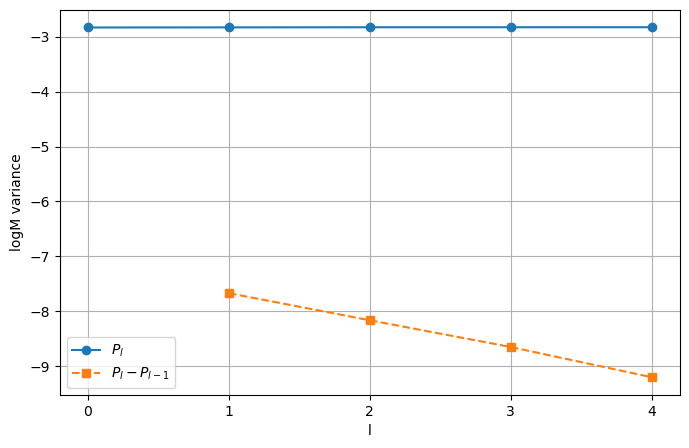

In [143]:
plt.figure(figsize=(8, 5))
plt.plot(np.log(V) / np.log(M), label=r'$P_l$', marker='o', linestyle='-')
plt.plot(np.log(V2) / np.log(M), label=r'$P_l-P_{l-1}$', marker='s', linestyle='--')


plt.xlabel("l")
plt.xticks([0, 1, 2, 3, 4]) 
plt.ylabel("logM variance")
#plt.title("LogM Value of V and V2")
plt.legend()
plt.grid(True)


plt.show()

C:\Users\Nvve\AppData\Local\Temp\ipykernel_17724\2738577475.py:6: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(P2) / np.log(M), label=r'$P_l-P_{l-1}$', marker='s', linestyle='--')
C:\Users\Nvve\AppData\Local\Temp\ipykernel_17724\2738577475.py:7: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(Y2) / np.log(M), label=r'$Y_l-Y_{l-1}/M$', marker='x', linestyle='-.')


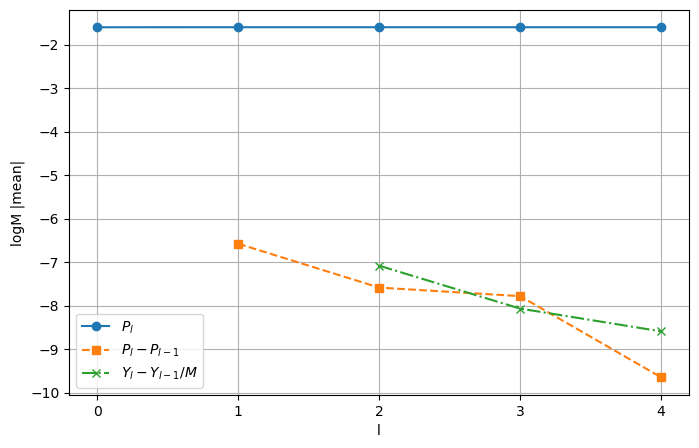

In [126]:
P2 = list(map(abs, Y))
Y2 = [0, 0] + [abs(Y[i]-Y[i-1]/4) for i in range(2, 5)]

plt.figure(figsize=(8, 5))
plt.plot(np.log(P) / np.log(M), label=r'$P_l$', marker='o', linestyle='-')
plt.plot(np.log(P2) / np.log(M), label=r'$P_l-P_{l-1}$', marker='s', linestyle='--')
plt.plot(np.log(Y2) / np.log(M), label=r'$Y_l-Y_{l-1}/M$', marker='x', linestyle='-.')

plt.xlabel("l")
plt.xticks([0, 1, 2, 3, 4]) 
plt.ylabel("logM |mean|")
#plt.title("Log4 Value of V and V2")
plt.legend()
plt.grid(True)


plt.show()

In [506]:
def sim_euro_heston_ext(
    dW1_coarse, dW2_coarse, dW1_fine, dW2_fine,
    n_paths=NL, dt_coarse=None, dt_fine=None,
    S0=1, V0=0.04, r=0.05, sigma=0.2, lambd=5.0, xi=0.25,
    T=1, K=1, p=1
):

    n_steps_coarse = int(T / dt_coarse)
    S_coarse = np.full(n_paths, S0, dtype=np.float64)
    V_coarse = np.full(n_paths, V0, dtype=np.float64)
    exp_lambd_dt_coarse = np.exp(-lambd * dt_coarse)
    for i in range(n_steps_coarse):
        sqrt_V = np.sqrt(np.maximum(V_coarse, 0))
        S_coarse += r * S_coarse * dt_coarse + sqrt_V * S_coarse * dW1_coarse[i]
        V_coarse = sigma**2 + exp_lambd_dt_coarse * (V_coarse - sigma**2) + xi * sqrt_V * dW2_coarse[i]
    payoff_coarse = np.exp(-r * T) * np.maximum(0, S_coarse - K)
    price_coarse = np.mean(payoff_coarse)

    n_steps_fine = int(T / dt_fine)
    S_fine = np.full(n_paths, S0, dtype=np.float64)
    V_fine = np.full(n_paths, V0, dtype=np.float64)
    exp_lambd_dt_fine = np.exp(-lambd * dt_fine)
    for i in range(n_steps_fine):
        sqrt_V = np.sqrt(np.maximum(V_fine, 0))
        S_fine += r * S_fine * dt_fine + sqrt_V * S_fine * dW1_fine[i]
        V_fine = sigma**2 + exp_lambd_dt_fine * (V_fine - sigma**2) + xi * sqrt_V * dW2_fine[i]
    payoff_fine = np.exp(-r * T) * np.maximum(0, S_fine - K)
    price_fine = np.mean(payoff_fine)
    

    price_extr = (2**p * price_fine - price_coarse) / (2**p - 1)
    variance = np.var(payoff_fine, ddof=1)
    
    return price_extr, variance, payoff_fine

In [520]:
def mlmc_heston_Richardson(L=5, err=1e-4, T=1.0, M=2, NL=10000, n_steps_base=100, rho=-0.5):
    dt_fine_base = T / (M**(L-1) * n_steps_base)
    def h(l):
        return dt_fine_base * M**((L-1) - l)
    
    dW_dict = {}

    dt_level = h(L-1)
    n_steps_fine = int(T / dt_level)
    dW1_fine, dW2_fine = generate_correlated_dW(n_steps_fine, NL, dt_level, rho)
    dW_dict[L-1] = (dW1_fine, dW2_fine)
    
    for l in range(L-2, -1, -1):
        dt_level = h(l)
        n_steps_level = int(T / dt_level)
        dW1_fine_prev, dW2_fine_prev = dW_dict[l+1]
        dW1_coarse = np.array([np.sum(dW1_fine_prev[i*M:(i+1)*M, :], axis=0)
                                for i in range(n_steps_level)])
        dW2_coarse = np.array([np.sum(dW2_fine_prev[i*M:(i+1)*M, :], axis=0)
                                for i in range(n_steps_level)])
        dW_dict[l] = (dW1_coarse, dW2_coarse)
    
    V = []    
    V2 = [0]  
    P = []    
    Pa = []  
    Y = [0]   
    N = []   
    l = 0
    converge = False


    #while l < L-1:
    while (l < 2 or not converge) and l < L-1:
        dt_coarse = h(l)      
        dt_fine   = h(l+1)   
        dW1_coarse, dW2_coarse = dW_dict[l]
        dW1_fine, dW2_fine     = dW_dict[l+1]
        
        pl, vl, parray = sim_euro_heston_ext(
            dW1_coarse, dW2_coarse, dW1_fine, dW2_fine,
            n_paths=NL, dt_coarse=dt_coarse, dt_fine=dt_fine, T=T
        )
        P.append(pl)
        V.append(vl)
        Pa.append(parray)
        
        #N = optimal_N(V, err)
        #Nl = N[-1]
        Nl = optimal_N(V, err)
        N.append(Nl)
        if l >= 1:
            diff = Pa[l][:N[-1]] - Pa[l-1][:N[-1]]
            Yl = np.mean(diff)
            v2 = np.var(diff, ddof=1)
            Y.append(Yl)
            V2.append(v2)
            if l >= 2:
                converge = (abs(Y[l]-Y[l-1]/M) < err*(M**2-1)/np.sqrt(2))
        l += 1

    dt_last = h(L-1)
    pl, vl, parray = sim_euro_heston(dW_dict[L-1][0], dW_dict[L-1][1], n_paths=NL, dt=dt_last, T=T)
    P.append(pl)
    V.append(vl)
    Pa.append(parray)
    
    return V, V2, P, Y, N

In [538]:
Nlist = []
for err in errs:
    _, _, _, _, Nx = mlmc_heston(err=err)
    Nlist.append(Nx)
    
costs = cal_cost(Nlist)

Nlist_ext = []
for err in errs:
    _, _, _, _, Nx = mlmc_heston_Richardson(err=err)
    Nlist_ext.append(Nx)

costs_ext = cal_cost(Nlist_ext)

costs_std = std_cost(V, Nlist)
costs_std_ext = std_cost(V, Nlist_ext)

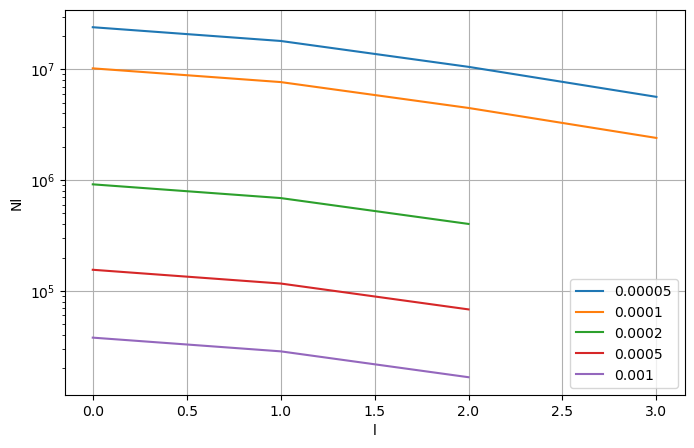

In [540]:
pltNlist(Nlist)

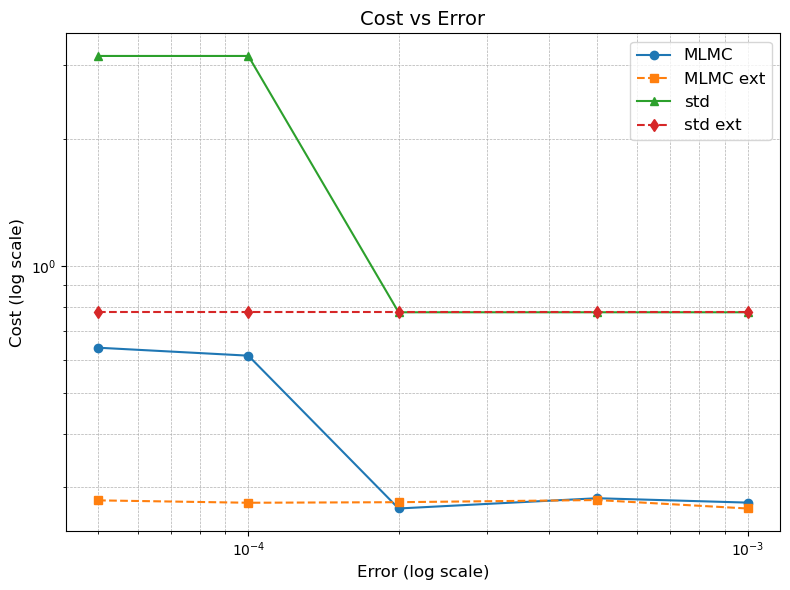

In [550]:
plt.figure(figsize=(8, 6))
plt.loglog(errs, costs, marker='o', linestyle='-', label='MLMC')
plt.loglog(errs, costs_ext, marker='s', linestyle='--', label='MLMC ext')
plt.loglog(errs, costs_std, marker='^', linestyle='-', label='std')
plt.loglog(errs, costs_std_ext, marker='d', linestyle='--', label='std ext')

plt.xlabel('Error (log scale)', fontsize=12)
plt.ylabel('Cost (log scale)', fontsize=12)
plt.title('Cost vs Error', fontsize=14)
plt.grid(True, which="both", ls="--", lw=0.5)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()